## Problem Statement

Our customer, Don Francesco, manages a large jewelry store and seeks to use a comprehensive dataset he has gathered to automatically determine the prices for diamonds customers want to sell to him.

This dataset includes details on the characteristics and prices of diamonds, which closely reflect actual market values.

Our goal is to develop a model that can accurately predict the market price of a diamond based on its characteristics.

### Dataset
The dataset provides information on diamond prices and their attributes that impact their value, expressed in 2008 US Dollars.

Key attributes include the 4 Cs: `carat`, `cut`, `color`, and `clarity`. It also includes physical measurements such as `depth`, `table`, and dimensions (`x`, `y`, `z`).

Additional information is available in the dataset readme.

### Caution 💀💀💀
I'm confident that my analysis is accurate and the model is ready for deployment. However, I had to write the code quickly and some sections might not be up to standard. I apologize for this. Please ensure the codebase is thoroughly refined and optimized.

## Data Understanding

## Data Exploration & Preparation


### Importing data
We base all our analysis on a CSV export of Don Francesco's database. There may be other samples, but that's all we were able to get.

In [1]:
import pandas as pd

diamonds = pd.read_csv("../data/diamonds_1.csv")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


First, let us check if there are really no missing data.

In [2]:
diamonds.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Great! No missing data.

Let us check the summary of the dataset.

In [3]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.00000
mean,0.787858,61.703075,57.46175,3818.526250,5.711968,5.715542,3.52527
std,0.461832,1.520990,2.32095,3799.545037,1.099723,1.091785,0.68698
min,0.230000,44.000000,52.00000,-1.000000,3.900000,3.900000,1.41000
25%,0.400000,61.000000,56.00000,946.000000,4.730000,4.720000,2.91000
50%,0.700000,61.800000,57.00000,2392.000000,5.680000,5.690000,3.52000
75%,1.020000,62.500000,59.00000,5236.750000,6.490000,6.510000,4.02000
max,3.010000,69.800000,95.00000,18705.000000,9.440000,9.370000,6.16000


There is something wrong. Negative prices and zero-dimensional stones are the result of mistakes.

In [4]:
diamonds[diamonds.x * diamonds.y * diamonds.z == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [5]:
diamonds[diamonds.price <= 0]

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.0,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99


That's not good. Let us remove those samples.

In [6]:
diamonds = diamonds[(diamonds.x * diamonds.y * diamonds.z != 0) & (diamonds.price > 0)]

Let us check again.

In [7]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000
mean,0.787804,61.702476,57.461115,3819.481370,5.711833,5.715424,3.525154
std,0.461877,1.520708,2.320893,3799.539906,1.099827,1.091895,0.687027
min,0.230000,44.000000,52.000000,351.000000,3.900000,3.900000,1.410000
25%,0.400000,61.000000,56.000000,946.000000,4.730000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2392.000000,5.680000,5.690000,3.520000
75%,1.020000,62.500000,59.000000,5238.500000,6.490000,6.510000,4.020000
max,3.010000,69.800000,95.000000,18705.000000,9.440000,9.370000,6.160000


Good, no more strange values. It looks like the distributions of the numerical variables are quite skewed: there are a few very big values and lots of smaller ones. Let us take a look to the charts.


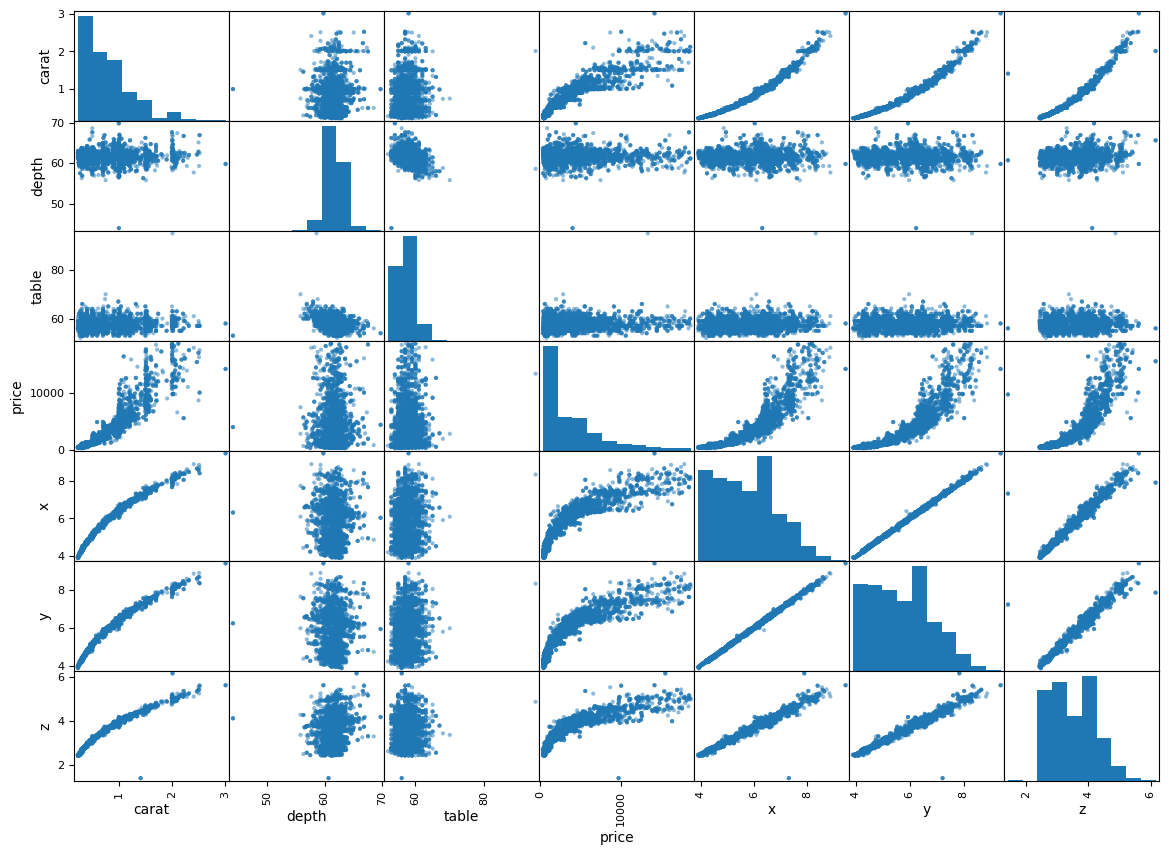

In [8]:
import numpy as np
from pandas.plotting import scatter_matrix

scatter_matrix(diamonds.select_dtypes(include=['number']), figsize=(14, 10));

We see several interesting things:
1. There are variables which does not look very correlated with the target (e.g table)
2. There are variables which look very correlated with the target, like carat, x, y and z, with non-linear patterns
3. There are variables which look correlated with each other (e.g. x, y and z)




Then, let us look into the distribution of single variables. We can use histograms.

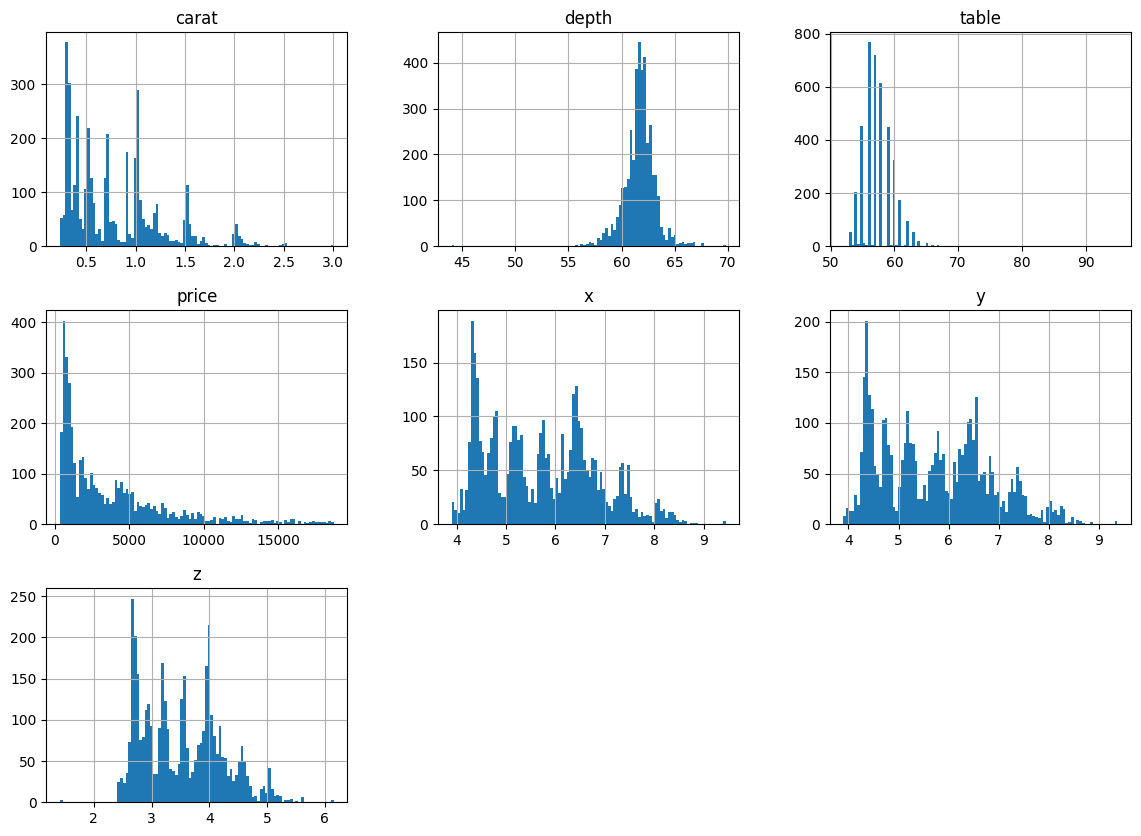

In [9]:
diamonds.hist(bins=100, figsize=(14, 10));

There are some outliers and it may be a good idea to remove them, but we will not do that at the moment.

Let us explore categorical variables: cut, color and clarity.

We can use box or violin charts.

In [10]:
import plotly.express as px

def plot_diamonds_price_by(diamonds_df, cut_column):
  return px.violin(diamonds_df, x=cut_column, y='price', color=cut_column, title=f'Price by {cut_column}')

In [11]:
plot_diamonds_price_by(diamonds, 'cut')

In [12]:
plot_diamonds_price_by(diamonds, 'color')

In [13]:
plot_diamonds_price_by(diamonds, 'clarity')

The distribution of the price differs with the values of each categorical variable. Therefore, it looks like all the variables may add relevant information.

To assess relationships between multiple variables, we need to map each one to a different graphical element, or aesthetic.

For instance, we can perform a scatter of price vs weight, with the categorical varaibles cut, color and clarity as color.

In [14]:
def scatter_diamods_by(diamonds_df, cut_column):
  return px.scatter(diamonds_df, x='carat', y='price', color=cut_column, title=f'Price vs carat with {cut_column}')

In [15]:
scatter_diamods_by(diamonds, 'cut')

In [16]:
scatter_diamods_by(diamonds, 'clarity')

In [17]:
scatter_diamods_by(diamonds, 'color')

The scatter plots confirm that all the categorical variables are relevant because, when we control for the weight of the stone, the categorical variables explain part of the remaining variance in the price.


## Linear Model

We'll begin with our preferred baseline: a straightforward, fully explainable linear model. However, we need to apply some transformations to the dataset before training the model.

### Data Preparation

First, we are going to drop all the irrelevant columns, namely depth and table.

Moreover, we also want to drop y and z, as they have high correlation with x.

In [18]:
diamonds_processed = diamonds.drop(columns=['depth', 'table', 'y', 'z'])
diamonds_processed.head()

,carat,cut,color,clarity,price,x
0,1.10,Ideal,H,SI2,4733,6.61
1,1.29,Ideal,H,SI1,6424,6.96
2,1.20,Premium,I,SI1,5510,6.88
3,1.50,Ideal,F,SI1,8770,7.43
4,0.90,Very Good,F,VS2,4493,6.17


Then, we are going to create dummy variables for cut, color and clarity.

Pandas has a very handy function for that.

In [19]:
diamonds_dummy = pd.get_dummies(diamonds_processed, columns=['cut', 'color', 'clarity'], drop_first=True)
diamonds_dummy.head()

,carat,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.10,4733,6.61,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,1.29,6424,6.96,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
2,1.20,5510,6.88,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,1.50,8770,7.43,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
4,0.90,4493,6.17,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False


I will now save the preprocessed data into a new csv file, so that i can work on it easily in other notebooks wothout the need of analyizing the data over and over


In [20]:
diamonds_dummy.to_csv('../data/diamonds_preprocessed.csv', index=False)

Finally, we split X and Y, train and test.

We go for a random 80/20 split.

In [21]:
from sklearn.model_selection import train_test_split

x = diamonds_dummy.drop(columns='price')
y = diamonds_dummy.price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Modelling & evaluation

We will use a simple linear regression model.

We train the model and we evaluate its out-of-sample performances using r squared and Mean Absolute Error (MAE).

In [22]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_test)

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error

print(f'R2 Score: {round(r2_score(y_test, pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, pred), 2)}$')

R2 Score: 0.8923
MAE: 683.26$


Let us visualize our results in a goodness of fit plot.

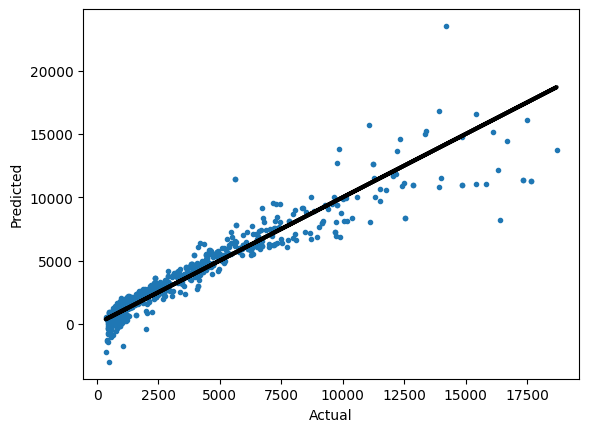

In [24]:
import matplotlib.pyplot as plt

def plot_gof(y_true: pd.Series, y_pred: pd.Series):
  plt.plot(y_true, y_pred, '.')
  plt.plot(y_true, y_true, linewidth=3, c='black')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()

plot_gof(y_test, pred)

That's not good at all. We have some negative predicted prices.

To avoid this issue, we can perform a log transformation on the target variable.

In [25]:
y_train_log = np.log(y_train)

reg = LinearRegression()
reg.fit(x_train, y_train_log)
pred_log = reg.predict(x_test)
pred = np.exp(pred_log)

And we can check the same metrics as before.


In [26]:
print(f'R2 Score: {round(r2_score(y_test, pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, pred), 2)}$')

R2 Score: 0.8636
MAE: 496.47$


Much, much better. Again, we can visually assess the improvement.

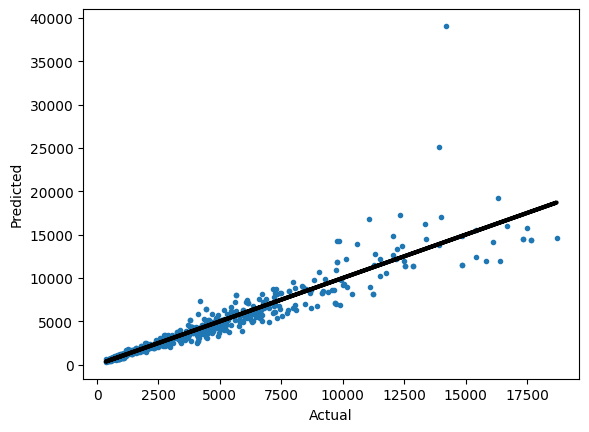

In [27]:
plot_gof(y_test, pred)

From now on i will save the new models into pickle files, so that it is easier to keep them up to date

to keep everything easy to read i will create a dictionary containg the name of the model and the model itself

In [28]:
# save the model to disk
import utils

utils.save_model(reg, 'linear_regression_diamonds')

In [29]:
# save the scores to disk as a csv file

utils.save_scores(y_test, pred, 'linear_regression_diamonds')

linear_regression_diamonds
{'r2_score': 0.8636199159608426, 'mae': 496.47421713536477}


## Gradient boosting
The linear regression is fun and simple, but more advanced models may be needed in order to achieve better performance. Let us try with xgboost.

### Data Preparation
We know that tree-based models do not suffer from collinear variables and prefer ordinal variables to categorical ones. Therefore, we need to change the preprocessing as well.

In [30]:
diamonds_processed_xgb = diamonds.copy()
diamonds_processed_xgb['cut'] = pd.Categorical(diamonds_processed_xgb['cut'], categories=['Fair', 'Good', 'Very Good', 'Ideal', 'Premium'], ordered=True)
diamonds_processed_xgb['color'] = pd.Categorical(diamonds_processed_xgb['color'], categories=['D', 'E', 'F', 'G', 'H', 'I', 'J'], ordered=True)
diamonds_processed_xgb['clarity'] = pd.Categorical(diamonds_processed_xgb['clarity'], categories=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], ordered=True)
diamonds_processed_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    3999 non-null   float64 
 1   cut      3999 non-null   category
 2   color    3999 non-null   category
 3   clarity  3999 non-null   category
 4   depth    3999 non-null   float64 
 5   table    3999 non-null   float64 
 6   price    3999 non-null   int64   
 7   x        3999 non-null   float64 
 8   y        3999 non-null   float64 
 9   z        3999 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 262.6 KB


By using the same random seed, we ensure that the same samples end up in the test set, therefore the comparison between models is fair.

In [31]:
x_train_xbg, x_test_xbg, y_train_xbg, y_test_xbg = train_test_split(diamonds_processed_xgb.drop(columns='price'), diamonds_processed_xgb['price'], test_size=0.2, random_state=42)

### Modelling and Evaluation
As before, we train the model and we evaluate it with the same metrics.

In [32]:
import xgboost

xgb = xgboost.XGBRegressor(enable_categorical=True, random_state=42)
xgb.fit(x_train_xbg, y_train_xbg)
xgb_pred = xgb.predict(x_test_xbg)

In [33]:
print(f'R2 Score: {round(r2_score(y_test_xbg, xgb_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test_xbg, xgb_pred), 2)}$')

R2 Score: 0.987
MAE: 120.23$


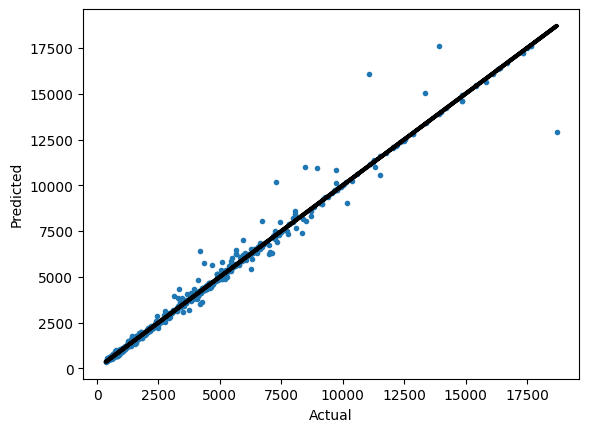

In [34]:
plot_gof(y_test_xbg, xgb_pred)

Much, much better. But we can do even better. Let's try and use optuna, a Bayesian hyperparameter tuning library.

In [35]:
!pip install --upgrade optuna

In [36]:
import optuna

def objective(trial: optuna.trial.Trial) -> float:
    # Define hyperparameters to tune
    param = {
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'enable_categorical': True
    }

    # Split the training data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train_xbg, y_train_xbg, test_size=0.2, random_state=42)

    # Train the model
    model = xgboost.XGBRegressor(**param)
    model.fit(x_train, y_train)

    # Make predictions
    preds = model.predict(x_val)

    # Calculate MAE
    mae = mean_absolute_error(y_val, preds)

    return mae

study = optuna.create_study(direction='minimize', study_name='Diamonds XGBoost')
study.optimize(objective, n_trials=100)
print("Best hyperparameters: ", study.best_params)

[I 2024-06-20 19:30:19,144] A new study created in memory with name: Diamonds XGBoost
[I 2024-06-20 19:30:19,485] Trial 0 finished with value: 2989.2236408233643 and parameters: {'lambda': 6.2691615711943006e-06, 'alpha': 0.14337473186791638, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 5.587927328875789e-08, 'n_estimators': 936, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 0 with value: 2989.2236408233643.
[I 2024-06-20 19:30:19,586] Trial 1 finished with value: 1355.5406518936156 and parameters: {'lambda': 0.0010223688774204183, 'alpha': 0.023024516601194686, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.004500911810155304, 'n_estimators': 189, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 1 with value: 1355.5406518936156.
[I 2024-06-20 19:30:19,691] Trial 2 finished with value: 734.4222728729249 and parameters: {'lambda': 1.7684166560041068e-06, 'alpha': 0.0005586766927119586, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate':

Best hyperparameters:  {'lambda': 0.003371015806075149, 'alpha': 7.355392073169829e-08, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.13658955308488768, 'n_estimators': 635, 'max_depth': 6, 'min_child_weight': 3}


Let's now re-train the model with the best set of hyperparameters.

In [37]:
xgb_opt = xgboost.XGBRegressor(**study.best_params, enable_categorical=True, random_state=42)
xgb_opt.fit(x_train_xbg, y_train_xbg)
xgb_opt_pred = xgb_opt.predict(x_test_xbg)

In [38]:
print(f'R2 Score: {round(r2_score(y_test_xbg, xgb_opt_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test_xbg, xgb_opt_pred), 2)}$')

R2 Score: 0.9865
MAE: 96.35$


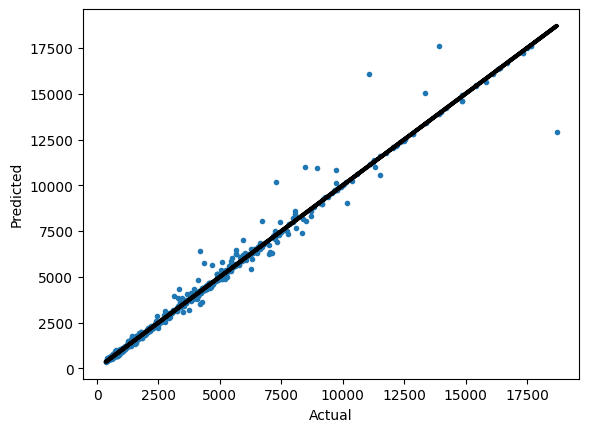

In [39]:
plot_gof(y_test_xbg, xgb_pred)

A modest improvement. The model performs well, especially for smaller and less expensive gems. However, it shows larger errors with bigger stones, which warrants further investigation. For now, this is acceptable.

In [40]:
# save the model and the scores to disk

utils.save_model(xgb_opt, 'xgboost_diamonds', 1)

utils.save_scores(y_test_xbg, xgb_opt_pred, 'xgboost_diamonds')

xgboost_diamonds
{'r2_score': 0.9864670038223267, 'mae': 96.34570610046387}
